In [4]:
import aim
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import sys

sys.path.append("..")

from source.model import *

In [5]:
path_ckpts = Path("..") / "weights"

epoch_number = 100

In [6]:
run_hash = "c2d94fea8bb94925bfaafb30"

path_softlock = Path("..") / ".aim" / "locks" / f"{run_hash}.softlock"
if path_softlock.exists():
    path_softlock.unlink()

repo_path = ".."
run = aim.Run(run_hash, repo=repo_path)
hparams = run["hparams"]
hparams

{'batch_size': 128,
 'dataset': 'fashion-mnist',
 'input_dim': 784,
 'kl_lambda': 1.0,
 'latent_dim': 10,
 'lr_decay_factor': 0.95,
 'lr_decay_rate': 10,
 'lr': 0.0002,
 'n_epochs': 200,
 'num_workers': 4,
 'random_seed': 10,
 'save_every': 50,
 'valid_every': 10}

In [7]:
model = VaDE(hparams["input_dim"], hparams["latent_dim"], hparams["n_clusters"])
ckpt = torch.load(path_ckpts / f"{run_hash}_{epoch_number}.pth")
model.load_state_dict(ckpt)
model.eval()


@torch.no_grad()
def sample_from_cluster(vade, cluster_id, n_samples):
    mu_c, log_sigma2_c = vade.mu_c[cluster_id], vade.log_sigma2_c[cluster_id]
    mu_c = mu_c.unsqueeze(0).repeat(n_samples, 1)
    log_sigma2_c = log_sigma2_c.unsqueeze(0).repeat(n_samples, 1)
    z = vade.sample_z(mu_c, log_sigma2_c)
    x_hat = vade.decoder(z)
    res = int(x_hat.shape[1] ** (1 / 2))
    return x_hat.reshape(x_hat.shape[0], res, res), z


samples = []
latents = []
n_samples_per_cluster = 8

cluster_idx = range(hparams["n_clusters"])

for cluster_id in cluster_idx:

    x_hat, z = sample_from_cluster(model, cluster_id, n_samples_per_cluster)

    if x_hat.ndim == 3:
        x_hat = x_hat.unsqueeze(1)

    samples.append(x_hat)
    latents.append(z)

samples_cat = torch.cat(samples)
x_grid = make_grid(samples_cat)

KeyError: 'n_clusters'

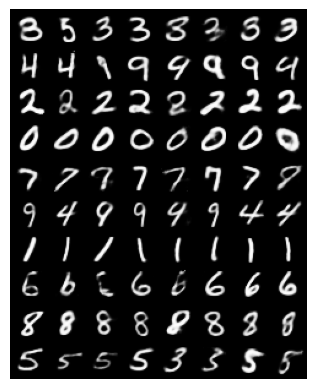

In [ ]:
def plot_grid(torch_grid):
    plt.imshow(torch_grid.permute(1, 2, 0).numpy(force=True))
    plt.axis("off")
    plt.show()


plot_grid(x_grid)

In [ ]:
sample_idx = 0
sample_in_out = []

for cluster_id in cluster_idx:
    latents_in = latents[cluster_id]
    latents_out = torch.cat(latents)

    cluster_samples_id_start = cluster_id * n_samples_per_cluster
    cluster_samples_id_end = (cluster_id + 1) * n_samples_per_cluster

    dists = (latents_out - latents_in[sample_idx]).norm(dim=1)
    dists_in = dists.clone()[cluster_samples_id_start:cluster_samples_id_end]
    dists_in[sample_idx] = float("inf")

    dists_out = dists.clone()
    dists_out[cluster_samples_id_start:cluster_samples_id_end] = float("inf")

    best_dist_in_id = cluster_samples_id_start + dists_in.argmin()
    best_dist_out_id = dists_out.argmin()

    sample_in_out += [
        samples_cat[cluster_samples_id_start + sample_idx],
        samples_cat[best_dist_in_id],
        samples_cat[best_dist_out_id],
    ]
sample_in_out_cat = torch.cat(sample_in_out)

if sample_in_out_cat.ndim == 3:
    sample_in_out_cat = sample_in_out_cat.unsqueeze(1)

in_out_grid = make_grid(sample_in_out_cat, nrow=3)

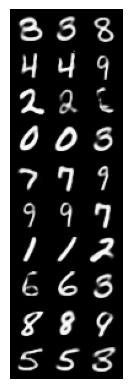

In [ ]:
plt.imshow(in_out_grid.permute(1, 2, 0).numpy(force=True))
plt.axis("off")
plt.show()